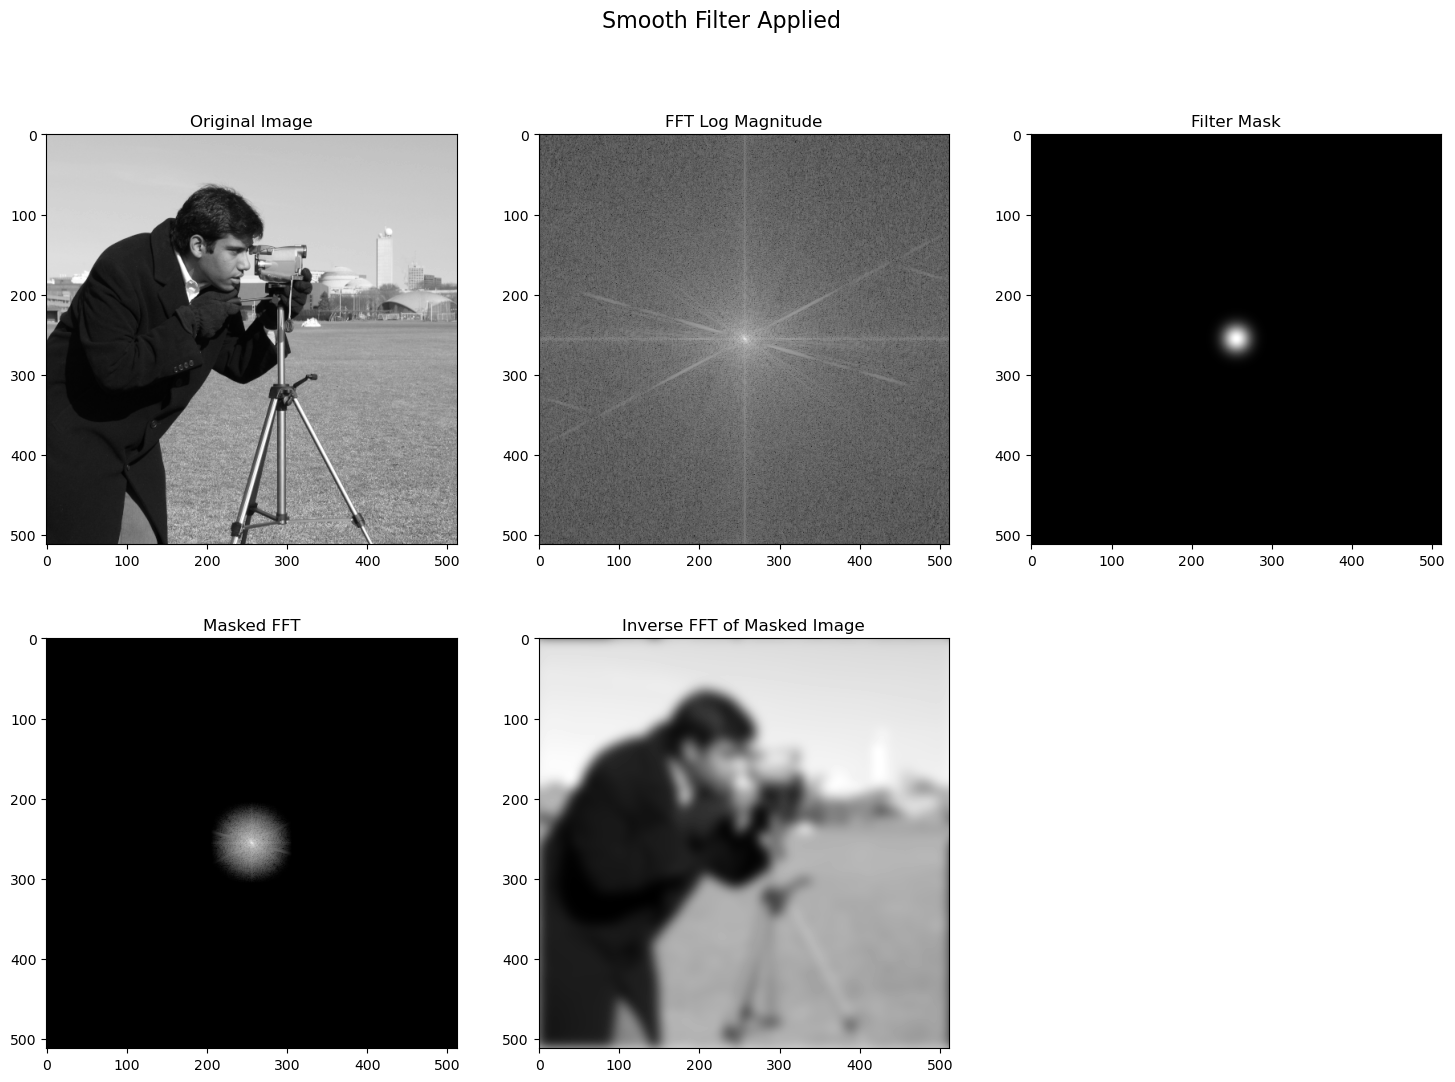

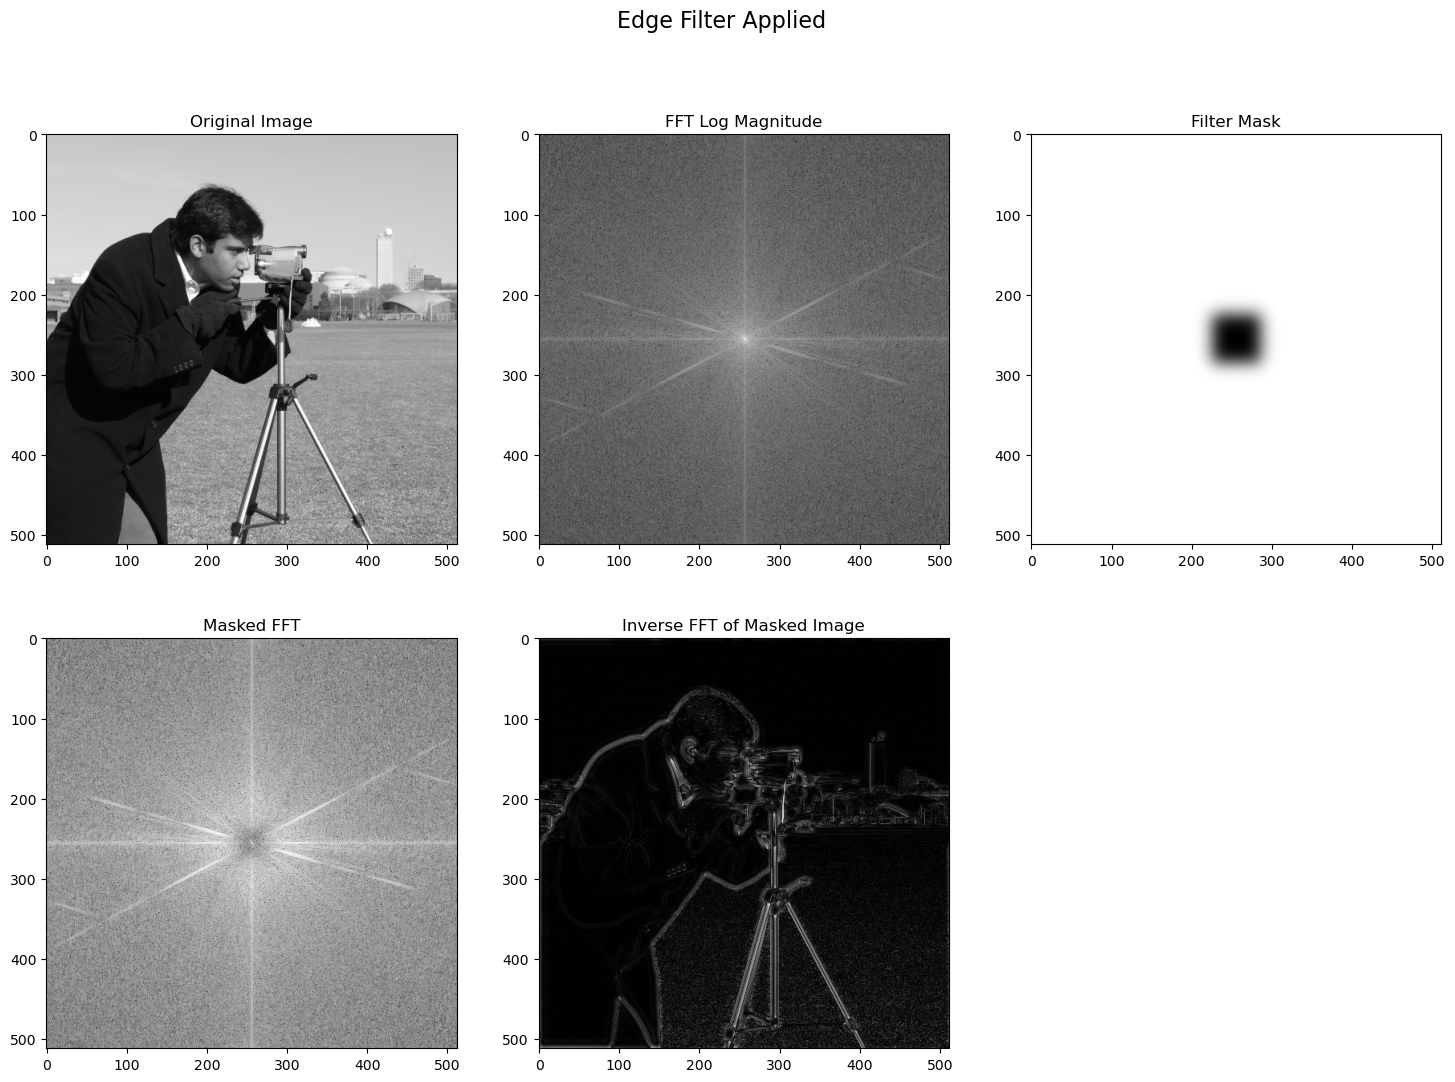

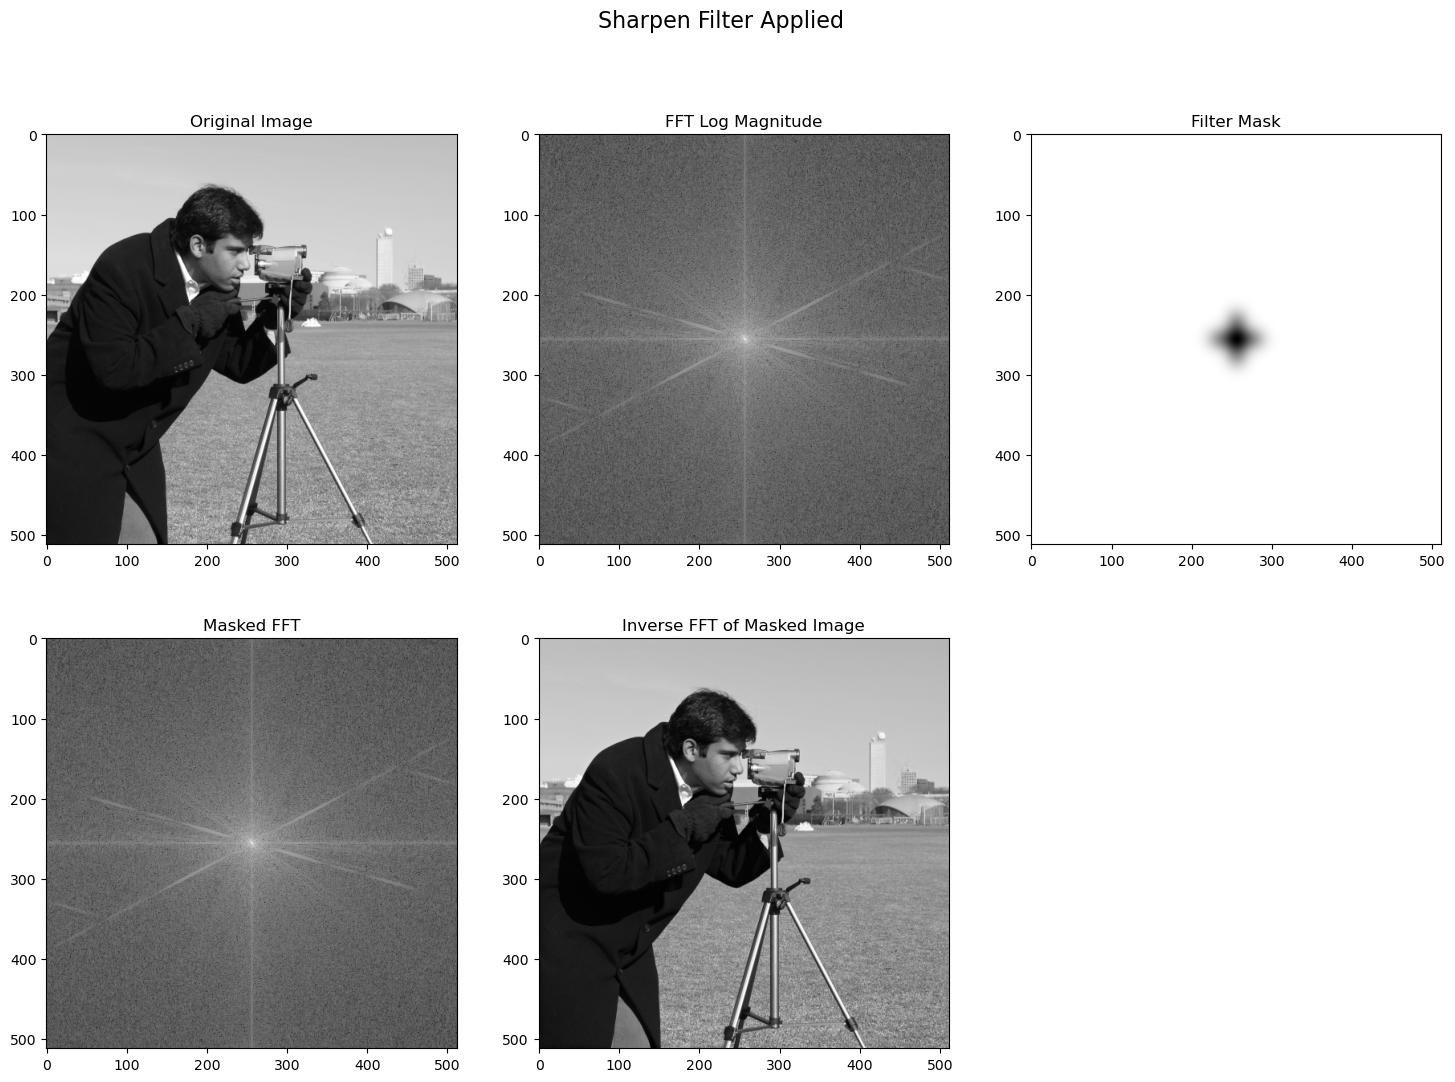

In [31]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft2, ifft2, fftshift, ifftshift
from scipy.ndimage import gaussian_filter
from skimage import data

# Load example image
image_data = data.camera()

# Display function with updated parameter names
def display_process(title, original_img, fft_log, mask_img, masked_fft, inverse_fft_img):
    fig, axs = plt.subplots(2, 3, figsize=(18, 12))
    axs = axs.ravel()  # Flatten the 2x3 array to a 1D array for simpler indexing
    
    axs[0].imshow(original_img, cmap='gray')
    axs[0].set_title('Original Image')
    axs[1].imshow(20 * np.log(np.abs(fft_log)), cmap='gray')
    axs[1].set_title('FFT Log Magnitude')
    axs[2].imshow(mask_img, cmap='gray')
    axs[2].set_title('Filter Mask')
    
    axs[3].imshow(np.log1p(np.abs(masked_fft)), cmap='gray')
    axs[3].set_title('Masked FFT')
    axs[4].imshow(inverse_fft_img, cmap='gray')
    axs[4].set_title('Inverse FFT of Masked Image')
    axs[5].axis('off')  # Hide the last subplot
    
    fig.suptitle(title, fontsize=16)
    plt.show()


# Fourier transform function
def perform_fft(image):
    transformed = fft2(image)
    shifted_transform = fftshift(transformed)
    return shifted_transform, np.abs(shifted_transform)

# Mask creation with modified logic and simplified parameters
def generate_mask(shape, filter_style, intensity, blur=10):
    rows, cols = shape
    center_row, center_col = rows // 2, cols // 2
    mask = np.ones(shape, dtype=np.float32)

    if filter_style == 'edge':
        mask[center_row - intensity:center_row + intensity, center_col - intensity:center_col + intensity] = 0
    elif filter_style == 'smooth':
        mask = np.zeros(shape)
        mask[center_row - intensity:center_row + intensity, center_col - intensity:center_col + intensity] = 1
    elif filter_style == 'sharpen':
        mask[center_row - intensity:center_row + intensity, center_col] = 0
        mask[center_row, center_col - intensity:center_col + intensity] = 0

    return gaussian_filter(mask, sigma=blur)

# Apply the mask to the FFT result
def mask_fft(shifted_fft, mask):
    return shifted_fft * mask

# Inverse FFT and transform
def compute_ifft(masked_fft):
    unshifted = ifftshift(masked_fft)
    reconstructed_img = np.abs(ifft2(unshifted))
    return reconstructed_img

# Main function to apply the filter
def process_image(image, filter_type, intensity):
    shifted_fft, fft_log_mag = perform_fft(image)
    mask = generate_mask(image.shape, filter_type, intensity)
    masked_fft = mask_fft(shifted_fft, mask)
    inverse_image = compute_ifft(masked_fft)

    display_process(f'{filter_type.capitalize()} Filter Applied', image, fft_log_mag, mask, masked_fft, inverse_image)

# Run the filter function on the image
process_image(image_data, 'smooth', 10)
process_image(image_data, 'edge', 30)
process_image(image_data, 'sharpen', 30)


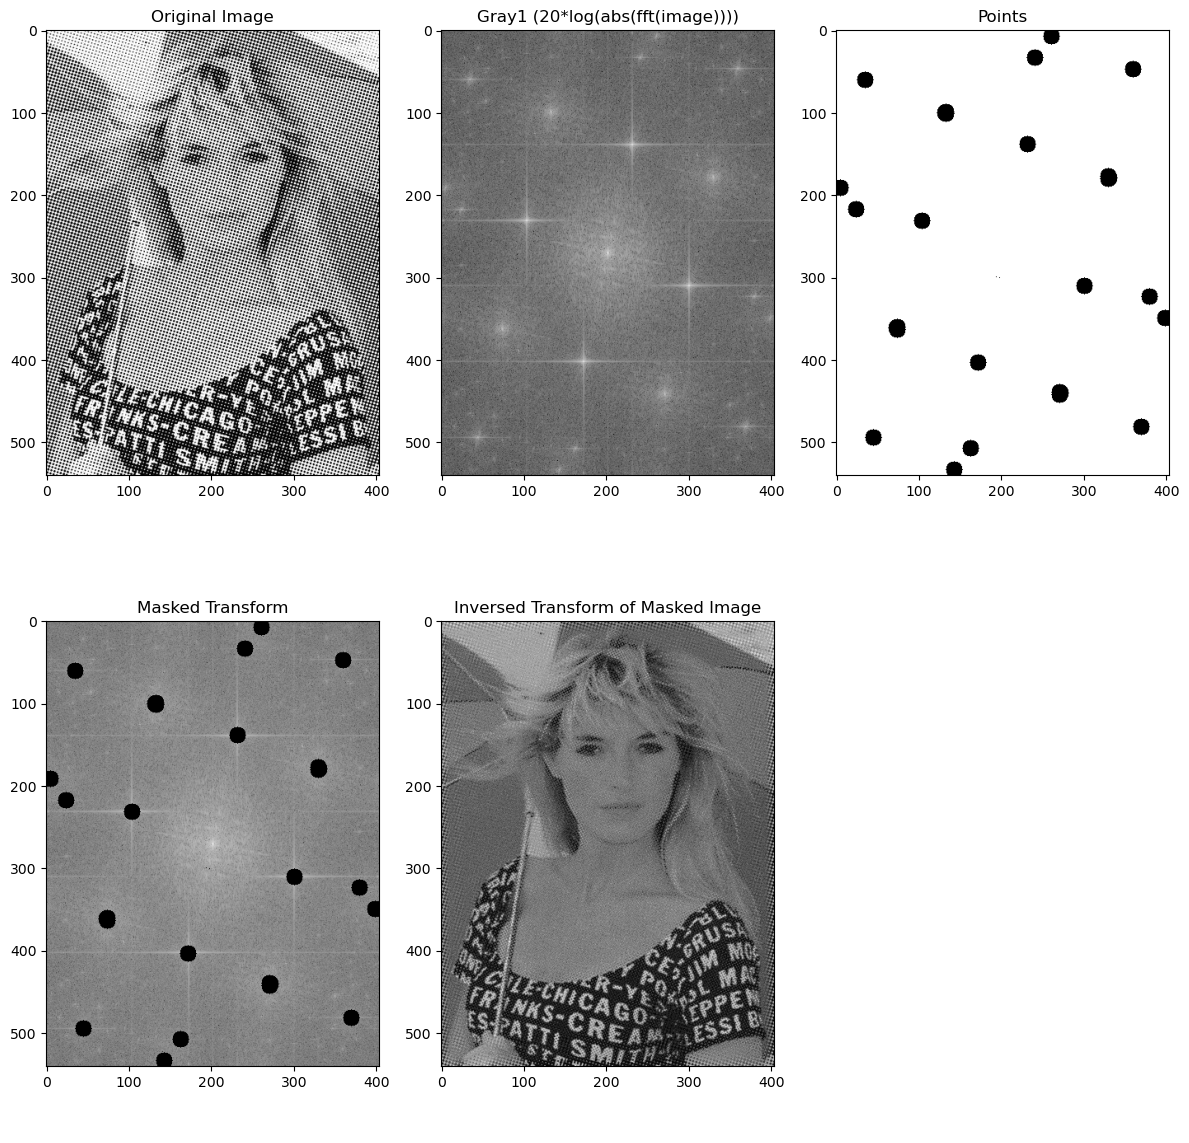

In [27]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import label, find_objects

# Load the grayscale image
original_image_path = 'gray1 (2).jpg'
original_image = cv2.imread(original_image_path, cv2.IMREAD_GRAYSCALE)

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 12))

# Flatten the 2x3 array of axes to make it easier to index
axes = axes.ravel()

# Step 1: Display the Original Image
axes[0].imshow(original_image, cmap='gray')
axes[0].set_title('Original Image')

# Step 2: Fourier Transform of the Image and Log Transformation
f_transform = np.fft.fft2(original_image)
f_shifted = np.fft.fftshift(f_transform)
magnitude_spectrum = 20 * np.log(np.abs(f_shifted)) 

axes[1].imshow(magnitude_spectrum, cmap='gray')
axes[1].set_title('Gray1 (20*log(abs(fft(image))))')

# Step 3: Detect Peaks (Points) and Display them as Uniform Black Dots on White Background
threshold = np.percentile(magnitude_spectrum, 99.85) 
binary_mask = (magnitude_spectrum > threshold).astype(np.uint8)

# Label connected components to find each peak region
labeled, num_features = label(binary_mask)
points_display = np.ones_like(magnitude_spectrum) * 255 

# Define the radius for each dot (make them look like circles)
dot_radius = 10  

# Iterate over each detected object and draw uniform black circles as dots
for slice_ in find_objects(labeled):
    center_y = (slice_[0].start + slice_[0].stop) // 2
    center_x = (slice_[1].start + slice_[1].stop) // 2
    rr, cc = np.ogrid[:points_display.shape[0], :points_display.shape[1]]
    mask = (rr - center_y)**2 + (cc - center_x)**2 <= dot_radius**2
    points_display[mask] = 0 

center_y, center_x = np.array(points_display.shape) // 2
central_radius = 30 
rr, cc = np.ogrid[:points_display.shape[0], :points_display.shape[1]]
center_mask = (rr - center_y)**2 + (cc - center_x)**2 <= central_radius**2
points_display[center_mask] = 255  

axes[2].imshow(points_display, cmap='gray')
axes[2].set_title('Points')

# Step 4: Apply Mask to the Frequency Domain
mask = np.ones_like(f_shifted, dtype=np.uint8)

# Set mask to zero where points are detected (black dots locations in points_display)
mask[points_display == 0] = 0  

# Apply the mask to the frequency domain (f_shifted)
masked_f_shifted = f_shifted * mask  

# Display the masked Fourier transform (Magnitude Spectrum with black dots masked)
masked_magnitude_spectrum = 20 * np.log(np.abs(masked_f_shifted) + 1)  
axes[3].imshow(masked_magnitude_spectrum, cmap='gray')
axes[3].set_title('Masked Transform')

# Step 5: Inverse Fourier Transform of Masked Image to Get Descreened Image
f_ishifted = np.fft.ifftshift(masked_f_shifted)  # Shift the zero-frequency component back
img_back = np.fft.ifft2(f_ishifted)  # Inverse FFT to get the image back
img_back = np.abs(img_back)  # Take the magnitude of the result (real part)

axes[4].imshow(img_back, cmap='gray')
axes[4].set_title('Inversed Transform of Masked Image')

axes[5].axis('off')

plt.tight_layout()
plt.show()
